In [1]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.colors import Normalize
from sklearn.feature_selection import f_classif, mutual_info_classif, VarianceThreshold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score
from skimage.morphology import dilation, square 
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))

from src.lib import utils
from src.lib import cell_blobs_skimage as blobsutils

In [2]:
def plot_ft_importance(ft_importance, columns):
    fig, ax = plt.subplots(1, figsize=(len(columns)*0.5,  6))
    cmap = cm.YlOrRd
    idx_sorting = ft_importance.argsort()
    sorted_ft_importance = ft_importance[idx_sorting]
    sorted_columns = columns[idx_sorting]

    norm = Normalize(vmin=sorted_ft_importance.min(), vmax=sorted_ft_importance.max())
    ax.bar(sorted_columns, sorted_ft_importance, color=cmap(norm(sorted_ft_importance)))
    ax.set_xticks(sorted_columns)
    ax.set_xticklabels(sorted_columns, rotation=45, ha='right', fontsize=12)
    ax.set_aspect('auto', adjustable='box')

    return fig, ax

In [3]:
df = pd.read_csv('../data/processed/2021-03-29_features.csv', index_col=0)
df.insert(0, 'protein', df.index.str.split("_").str[0])
df.insert(1, 'plate', df.index.str.split("_").str[1])
df.insert(2, 'stimulus', df.index.str.split("_").str[2])
df_negsi = df[(df['protein'] == 'NegsiRNA') & df['stimulus'].isin(['NO', 'NS'])]
X = df_negsi.iloc[:, 3:]
X

,white_area_ratio,area_mean,area_std,area_median,area_mad,area_mode,perimeter_mean,perimeter_std,perimeter_median,perimeter_mad,...,texture_std_filter_mad,texture_std_filter_mode,texture_entropy_filter_mean,texture_entropy_filter_std,texture_entropy_filter_median,texture_entropy_filter_mad,texture_entropy_filter_mode,global_entropy_discrete,global_entropy_kde,global_coeff_var
NegsiRNA_E3_NO,0.297828,9152.662983,5861.016265,8733.0,4082.0,324,420.311546,159.207715,437.830519,116.509668,...,380.513855,696.241333,3.656484,0.564080,3.654402,0.401522,3.590049,4.918801,4.929815,0.507799
NegsiRNA_L2_NS,0.188984,16354.025641,11973.890243,14692.0,7801.0,133,570.751082,272.290111,590.150324,166.775649,...,338.279541,625.615723,3.548006,0.576589,3.554798,0.407309,3.542132,4.889136,4.899215,0.469468
NegsiRNA_H3_NO,0.331324,9066.666667,4624.803328,9137.0,3065.5,2767,420.014121,125.327416,433.667568,82.961941,...,699.341797,1050.947021,4.108348,0.547412,4.139921,0.398159,4.303238,5.739097,5.753138,0.584560
NegsiRNA_G3_NS,0.239506,12123.135135,6724.839819,11964.0,4811.0,25070,482.741303,162.521925,496.830519,100.961941,...,437.898560,718.552246,3.727769,0.585909,3.736361,0.411526,3.773858,5.055952,5.069138,0.544023
NegsiRNA_B1_NO,0.334231,8490.518919,4554.174853,7825.0,3243.0,2548,404.229391,126.255607,399.237590,87.865007,...,444.087952,922.306763,3.842831,0.532055,3.856772,0.370482,3.915092,5.285276,5.295932,0.495018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NegsiRNA_I2_NO,0.294810,9191.983425,6589.745374,8377.0,4311.0,4017,421.403050,184.206683,428.475180,126.183766,...,686.875854,1228.524170,4.171937,0.520124,4.206675,0.366820,4.412320,5.880329,5.893349,0.571624
NegsiRNA_G3_NO,0.308489,10733.375000,6908.580970,9617.5,4078.5,306,481.153957,177.158340,474.140656,112.535534,...,465.872162,900.640015,3.845423,0.540924,3.858810,0.382282,3.969106,5.163923,5.175285,0.507955
NegsiRNA_A1_NO,0.298644,13177.889831,7140.607112,13257.5,4826.0,4293,506.398803,170.840229,530.445743,114.376154,...,801.106934,1262.257812,4.164838,0.564305,4.224119,0.398159,4.482996,5.802308,5.821928,0.563054
NegsiRNA_I3_NO,0.287247,10919.454545,7043.811285,10218.0,4508.0,175,466.969360,188.406991,469.747258,116.053824,...,498.391846,889.823975,3.831053,0.584908,3.850988,0.418639,4.036613,5.223986,5.236625,0.531850


In [4]:
y = df_negsi['stimulus']
y

NegsiRNA_E3_NO    NO
NegsiRNA_L2_NS    NS
NegsiRNA_H3_NO    NO
NegsiRNA_G3_NS    NS
NegsiRNA_B1_NO    NO
                  ..
NegsiRNA_I2_NO    NO
NegsiRNA_G3_NO    NO
NegsiRNA_A1_NO    NO
NegsiRNA_I3_NO    NO
NegsiRNA_H3_NS    NS
Name: stimulus, Length: 68, dtype: object

### Remove features with NaN values

In [5]:
has_nan = (X.isna().sum() > 0)
X = X[has_nan[~has_nan].index]
X

,white_area_ratio,area_mean,area_std,area_median,area_mad,area_mode,perimeter_mean,perimeter_std,perimeter_median,perimeter_mad,...,texture_std_filter_mad,texture_std_filter_mode,texture_entropy_filter_mean,texture_entropy_filter_std,texture_entropy_filter_median,texture_entropy_filter_mad,texture_entropy_filter_mode,global_entropy_discrete,global_entropy_kde,global_coeff_var
NegsiRNA_E3_NO,0.297828,9152.662983,5861.016265,8733.0,4082.0,324,420.311546,159.207715,437.830519,116.509668,...,380.513855,696.241333,3.656484,0.564080,3.654402,0.401522,3.590049,4.918801,4.929815,0.507799
NegsiRNA_L2_NS,0.188984,16354.025641,11973.890243,14692.0,7801.0,133,570.751082,272.290111,590.150324,166.775649,...,338.279541,625.615723,3.548006,0.576589,3.554798,0.407309,3.542132,4.889136,4.899215,0.469468
NegsiRNA_H3_NO,0.331324,9066.666667,4624.803328,9137.0,3065.5,2767,420.014121,125.327416,433.667568,82.961941,...,699.341797,1050.947021,4.108348,0.547412,4.139921,0.398159,4.303238,5.739097,5.753138,0.584560
NegsiRNA_G3_NS,0.239506,12123.135135,6724.839819,11964.0,4811.0,25070,482.741303,162.521925,496.830519,100.961941,...,437.898560,718.552246,3.727769,0.585909,3.736361,0.411526,3.773858,5.055952,5.069138,0.544023
NegsiRNA_B1_NO,0.334231,8490.518919,4554.174853,7825.0,3243.0,2548,404.229391,126.255607,399.237590,87.865007,...,444.087952,922.306763,3.842831,0.532055,3.856772,0.370482,3.915092,5.285276,5.295932,0.495018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NegsiRNA_I2_NO,0.294810,9191.983425,6589.745374,8377.0,4311.0,4017,421.403050,184.206683,428.475180,126.183766,...,686.875854,1228.524170,4.171937,0.520124,4.206675,0.366820,4.412320,5.880329,5.893349,0.571624
NegsiRNA_G3_NO,0.308489,10733.375000,6908.580970,9617.5,4078.5,306,481.153957,177.158340,474.140656,112.535534,...,465.872162,900.640015,3.845423,0.540924,3.858810,0.382282,3.969106,5.163923,5.175285,0.507955
NegsiRNA_A1_NO,0.298644,13177.889831,7140.607112,13257.5,4826.0,4293,506.398803,170.840229,530.445743,114.376154,...,801.106934,1262.257812,4.164838,0.564305,4.224119,0.398159,4.482996,5.802308,5.821928,0.563054
NegsiRNA_I3_NO,0.287247,10919.454545,7043.811285,10218.0,4508.0,175,466.969360,188.406991,469.747258,116.053824,...,498.391846,889.823975,3.831053,0.584908,3.850988,0.418639,4.036613,5.223986,5.236625,0.531850


In [6]:
print(f"Removed {len(has_nan[has_nan])} features with NaN values: {', '.join(has_nan[has_nan].index)}")

Removed 3 features with NaN values: e2e_distance_std, e2e_eu_distance_std, e2e_distance_ratio_std


Looking into the features that were removed, we can see that all of them are standard deviations for length measures of a specific kind of skeleton branch (end to end, _e2e_). Those features had NaN values, which means that there are not enough values to compute the standard deviation. Looking deeper into those measures, we realized that the number of branches of that kind is really small (< 12) for all the samples, so we decided to remove all the features related to that kind of branch.

In [7]:
e2e_cols = [col for col in X.columns if col.startswith('e2e')]
X = X.drop(columns=e2e_cols)
print(f"Removed {len(e2e_cols)} e2e branch features: {', '.join(e2e_cols)}")

Removed 13 e2e branch features: e2e_n, e2e_distance_mean, e2e_distance_median, e2e_distance_mad, e2e_distance_mode, e2e_eu_distance_mean, e2e_eu_distance_median, e2e_eu_distance_mad, e2e_eu_distance_mode, e2e_distance_ratio_mean, e2e_distance_ratio_median, e2e_distance_ratio_mad, e2e_distance_ratio_mode


### Remove features with constant value

In [8]:
vt_selector = VarianceThreshold()
vt_selector.fit(X)
selected = vt_selector.get_support()
non_selected_names = X.columns[np.where(~selected)[0]]
X = X.iloc[:, np.where(selected)[0]]
X

,white_area_ratio,area_mean,area_std,area_median,area_mad,area_mode,perimeter_mean,perimeter_std,perimeter_median,perimeter_mad,...,texture_std_filter_mad,texture_std_filter_mode,texture_entropy_filter_mean,texture_entropy_filter_std,texture_entropy_filter_median,texture_entropy_filter_mad,texture_entropy_filter_mode,global_entropy_discrete,global_entropy_kde,global_coeff_var
NegsiRNA_E3_NO,0.297828,9152.662983,5861.016265,8733.0,4082.0,324,420.311546,159.207715,437.830519,116.509668,...,380.513855,696.241333,3.656484,0.564080,3.654402,0.401522,3.590049,4.918801,4.929815,0.507799
NegsiRNA_L2_NS,0.188984,16354.025641,11973.890243,14692.0,7801.0,133,570.751082,272.290111,590.150324,166.775649,...,338.279541,625.615723,3.548006,0.576589,3.554798,0.407309,3.542132,4.889136,4.899215,0.469468
NegsiRNA_H3_NO,0.331324,9066.666667,4624.803328,9137.0,3065.5,2767,420.014121,125.327416,433.667568,82.961941,...,699.341797,1050.947021,4.108348,0.547412,4.139921,0.398159,4.303238,5.739097,5.753138,0.584560
NegsiRNA_G3_NS,0.239506,12123.135135,6724.839819,11964.0,4811.0,25070,482.741303,162.521925,496.830519,100.961941,...,437.898560,718.552246,3.727769,0.585909,3.736361,0.411526,3.773858,5.055952,5.069138,0.544023
NegsiRNA_B1_NO,0.334231,8490.518919,4554.174853,7825.0,3243.0,2548,404.229391,126.255607,399.237590,87.865007,...,444.087952,922.306763,3.842831,0.532055,3.856772,0.370482,3.915092,5.285276,5.295932,0.495018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NegsiRNA_I2_NO,0.294810,9191.983425,6589.745374,8377.0,4311.0,4017,421.403050,184.206683,428.475180,126.183766,...,686.875854,1228.524170,4.171937,0.520124,4.206675,0.366820,4.412320,5.880329,5.893349,0.571624
NegsiRNA_G3_NO,0.308489,10733.375000,6908.580970,9617.5,4078.5,306,481.153957,177.158340,474.140656,112.535534,...,465.872162,900.640015,3.845423,0.540924,3.858810,0.382282,3.969106,5.163923,5.175285,0.507955
NegsiRNA_A1_NO,0.298644,13177.889831,7140.607112,13257.5,4826.0,4293,506.398803,170.840229,530.445743,114.376154,...,801.106934,1262.257812,4.164838,0.564305,4.224119,0.398159,4.482996,5.802308,5.821928,0.563054
NegsiRNA_I3_NO,0.287247,10919.454545,7043.811285,10218.0,4508.0,175,466.969360,188.406991,469.747258,116.053824,...,498.391846,889.823975,3.831053,0.584908,3.850988,0.418639,4.036613,5.223986,5.236625,0.531850


In [9]:
print(f"Removed {len(np.where(~selected)[0])} features with constant values: {', '.join(non_selected_names)}")

Removed 3 features with constant values: nodes_median, nodes_mad, nodes_mode


The three features that were removed are related to the degree of the nodes (vertices). We should look further into it, so we are going to analyze the variability of the remaining node features.

In [10]:
X[(col for col in X.columns if col.startswith('nodes'))].describe()

,nodes_n,nodes_max,nodes_mean,nodes_std
count,68.000000,68.000000,68.000000,68.000000
mean,1813.941176,5.058824,3.130788,0.344417
std,290.680770,0.381762,0.011429,0.017567
min,998.000000,4.000000,3.099608,0.299476
25%,1636.750000,5.000000,3.124607,0.336184
50%,1805.000000,5.000000,3.127972,0.341051
75%,1973.750000,5.000000,3.137634,0.352765
max,2556.000000,6.000000,3.186493,0.439495


All those features are almost constant, except nodes_n. So we are removing those features.

In [11]:
nodes_cols = ['nodes_max', 'nodes_mean', 'nodes_std']
X = X.drop(columns=nodes_cols)
print(f"Removed {len(nodes_cols)} e2e branch features: {', '.join(nodes_cols)}")

Removed 3 e2e branch features: nodes_max, nodes_mean, nodes_std


In [12]:
cols2drop = [col for col in X.columns if col.split("_")[-1] in ['mean', 'std', 'mad', 'mode']]
X = X.drop(columns=cols2drop)

In [13]:
X

,white_area_ratio,area_median,perimeter_median,hull_area_median,hull_perimeter_median,compactness_median,solidity_median,convexity_median,major_axis_length_median,minor_axis_length_median,...,total_area_blobs>70000,percentage_area_blobs<1000,percentage_area_blobs>70000,branch_thickness_medial_axis_median,branch_thickness_voronoi_median,texture_std_filter_median,texture_entropy_filter_median,global_entropy_discrete,global_entropy_kde,global_coeff_var
NegsiRNA_E3_NO,0.297828,8733.0,437.830519,9924.0,397.847763,0.613938,0.919441,0.933102,133.559544,86.010926,...,0,0.002502,0.0,8.062258,8.944272,1037.078857,3.654402,4.918801,4.929815,0.507799
NegsiRNA_L2_NS,0.188984,14692.0,590.150324,16823.0,519.043723,0.574243,0.908038,0.924152,182.135618,111.411071,...,0,0.001270,0.0,5.656854,6.000000,937.887817,3.554798,4.889136,4.899215,0.469468
NegsiRNA_H3_NO,0.331324,9137.0,433.667568,10131.0,403.856385,0.614409,0.918018,0.945185,134.936639,90.564160,...,0,0.000948,0.0,9.486833,10.295630,1728.560547,4.139921,5.739097,5.753138,0.584560
NegsiRNA_G3_NS,0.239506,11964.0,496.830519,13573.5,468.910209,0.616320,0.924107,0.953916,162.089037,103.957252,...,0,0.000813,0.0,7.071068,7.615773,1131.844849,3.736361,5.055952,5.069138,0.544023
NegsiRNA_B1_NO,0.334231,7825.0,399.237590,8717.0,381.119841,0.651737,0.924544,0.953457,133.792300,83.211141,...,0,0.001234,0.0,9.219544,10.000000,1264.981201,3.856772,5.285276,5.295932,0.495018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NegsiRNA_I2_NO,0.294810,8377.0,428.475180,9598.0,398.232539,0.590679,0.909091,0.941260,137.045692,87.013677,...,0,0.003459,0.0,8.000000,8.544003,1820.860474,4.206675,5.880329,5.893349,0.571624
NegsiRNA_G3_NO,0.308489,9617.5,474.140656,10973.0,432.814755,0.552337,0.905983,0.920725,154.084236,88.794505,...,0,0.001170,0.0,8.944272,9.899495,1272.488770,3.858810,5.163923,5.175285,0.507955
NegsiRNA_A1_NO,0.298644,13257.5,530.445743,14905.5,492.508189,0.608864,0.923012,0.938238,163.928752,107.555366,...,0,0.001236,0.0,10.000000,11.000000,1963.717041,4.224119,5.802308,5.821928,0.563054
NegsiRNA_I3_NO,0.287247,10218.0,469.747258,11307.0,435.475180,0.594003,0.913212,0.940686,148.858167,90.554916,...,0,0.001028,0.0,8.000000,8.944272,1261.758423,3.850988,5.223986,5.236625,0.531850


### Remove features based on mutual information and F-score

In [14]:
blobs_features = ['area', 'perimeter', 'hull_area', 'hull_perimeter', 'compactness', 'solidity', 'convexity', 'major_axis_length', 'minor_axis_length', 'elongation']

In [15]:
blobs_cols = [col for col in X.columns if col.startswith(tuple(blobs_features)) and 'borderless' not in col and '>900' not in col]
blobs_cols, len(blobs_cols)

(['area_median',
  'perimeter_median',
  'hull_area_median',
  'hull_perimeter_median',
  'compactness_median',
  'solidity_median',
  'convexity_median',
  'major_axis_length_median',
  'minor_axis_length_median',
  'elongation_median'],
 10)

In [16]:
blobs_borderless_cols = [col for col in X.columns if col.startswith(tuple(blobs_features)) and 'borderless' in col]
blobs_borderless_cols, len(blobs_cols)

(['area_borderless_median',
  'perimeter_borderless_median',
  'hull_area_borderless_median',
  'hull_perimeter_borderless_median',
  'compactness_borderless_median',
  'solidity_borderless_median',
  'convexity_borderless_median',
  'major_axis_length_borderless_median',
  'minor_axis_length_borderless_median',
  'elongation_borderless_median'],
 10)

In [17]:
blobs_no_small_cols = [col for col in X.columns if col.startswith(tuple(blobs_features)) and '>900' in col]
blobs_no_small_cols, len(blobs_no_small_cols)

(['area_>900_median',
  'perimeter_>900_median',
  'hull_area_>900_median',
  'hull_perimeter_>900_median',
  'compactness_>900_median',
  'solidity_>900_median',
  'convexity_>900_median',
  'major_axis_length_>900_median',
  'minor_axis_length_>900_median',
  'elongation_>900_median'],
 10)

In [18]:
rest_cols = [col for col in X.columns if not col.startswith(tuple(blobs_features))]
rest_cols, len(rest_cols)

(['white_area_ratio',
  'blobs_n',
  'blobs_borderless_n',
  'blobs_>900_n',
  'j2e_n',
  'j2e_distance_median',
  'j2e_eu_distance_median',
  'j2e_distance_ratio_median',
  'j2j_n',
  'j2j_distance_median',
  'j2j_eu_distance_median',
  'j2j_distance_ratio_median',
  'nodes_n',
  'nuclei_n',
  'nuclei_blobs_ratio',
  'blobs_<1000_ratio',
  'total_area_blobs<1000',
  'total_area_blobs>70000',
  'percentage_area_blobs<1000',
  'percentage_area_blobs>70000',
  'branch_thickness_medial_axis_median',
  'branch_thickness_voronoi_median',
  'texture_std_filter_median',
  'texture_entropy_filter_median',
  'global_entropy_discrete',
  'global_entropy_kde',
  'global_coeff_var'],
 27)

In [19]:
X_all = X[blobs_cols + rest_cols]
X_all

,area_median,perimeter_median,hull_area_median,hull_perimeter_median,compactness_median,solidity_median,convexity_median,major_axis_length_median,minor_axis_length_median,elongation_median,...,total_area_blobs>70000,percentage_area_blobs<1000,percentage_area_blobs>70000,branch_thickness_medial_axis_median,branch_thickness_voronoi_median,texture_std_filter_median,texture_entropy_filter_median,global_entropy_discrete,global_entropy_kde,global_coeff_var
NegsiRNA_E3_NO,8733.0,437.830519,9924.0,397.847763,0.613938,0.919441,0.933102,133.559544,86.010926,1.490996,...,0,0.002502,0.0,8.062258,8.944272,1037.078857,3.654402,4.918801,4.929815,0.507799
NegsiRNA_L2_NS,14692.0,590.150324,16823.0,519.043723,0.574243,0.908038,0.924152,182.135618,111.411071,1.564275,...,0,0.001270,0.0,5.656854,6.000000,937.887817,3.554798,4.889136,4.899215,0.469468
NegsiRNA_H3_NO,9137.0,433.667568,10131.0,403.856385,0.614409,0.918018,0.945185,134.936639,90.564160,1.522873,...,0,0.000948,0.0,9.486833,10.295630,1728.560547,4.139921,5.739097,5.753138,0.584560
NegsiRNA_G3_NS,11964.0,496.830519,13573.5,468.910209,0.616320,0.924107,0.953916,162.089037,103.957252,1.605516,...,0,0.000813,0.0,7.071068,7.615773,1131.844849,3.736361,5.055952,5.069138,0.544023
NegsiRNA_B1_NO,7825.0,399.237590,8717.0,381.119841,0.651737,0.924544,0.953457,133.792300,83.211141,1.566899,...,0,0.001234,0.0,9.219544,10.000000,1264.981201,3.856772,5.285276,5.295932,0.495018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NegsiRNA_I2_NO,8377.0,428.475180,9598.0,398.232539,0.590679,0.909091,0.941260,137.045692,87.013677,1.608352,...,0,0.003459,0.0,8.000000,8.544003,1820.860474,4.206675,5.880329,5.893349,0.571624
NegsiRNA_G3_NO,9617.5,474.140656,10973.0,432.814755,0.552337,0.905983,0.920725,154.084236,88.794505,1.688006,...,0,0.001170,0.0,8.944272,9.899495,1272.488770,3.858810,5.163923,5.175285,0.507955
NegsiRNA_A1_NO,13257.5,530.445743,14905.5,492.508189,0.608864,0.923012,0.938238,163.928752,107.555366,1.549009,...,0,0.001236,0.0,10.000000,11.000000,1963.717041,4.224119,5.802308,5.821928,0.563054
NegsiRNA_I3_NO,10218.0,469.747258,11307.0,435.475180,0.594003,0.913212,0.940686,148.858167,90.554916,1.594342,...,0,0.001028,0.0,8.000000,8.944272,1261.758423,3.850988,5.223986,5.236625,0.531850


In [20]:
X_borderless = X[blobs_borderless_cols + rest_cols]
X_borderless

,area_borderless_median,perimeter_borderless_median,hull_area_borderless_median,hull_perimeter_borderless_median,compactness_borderless_median,solidity_borderless_median,convexity_borderless_median,major_axis_length_borderless_median,minor_axis_length_borderless_median,elongation_borderless_median,...,total_area_blobs>70000,percentage_area_blobs<1000,percentage_area_blobs>70000,branch_thickness_medial_axis_median,branch_thickness_voronoi_median,texture_std_filter_median,texture_entropy_filter_median,global_entropy_discrete,global_entropy_kde,global_coeff_var
NegsiRNA_E3_NO,9606.0,453.102597,10722.5,415.575685,0.614781,0.916856,0.927603,138.763417,93.240711,1.448576,...,0,0.002502,0.0,8.062258,8.944272,1037.078857,3.654402,4.918801,4.929815,0.507799
NegsiRNA_L2_NS,16789.0,607.913780,20168.0,567.997041,0.584323,0.907328,0.925205,196.835278,121.877248,1.523195,...,0,0.001270,0.0,5.656854,6.000000,937.887817,3.554798,4.889136,4.899215,0.469468
NegsiRNA_H3_NO,9941.0,456.357431,11255.0,421.989899,0.616945,0.915551,0.937294,140.981550,96.936772,1.472948,...,0,0.000948,0.0,9.486833,10.295630,1728.560547,4.139921,5.739097,5.753138,0.584560
NegsiRNA_G3_NS,13736.0,523.730014,15343.0,496.759451,0.612040,0.911647,0.944047,168.974462,109.523363,1.521927,...,0,0.000813,0.0,7.071068,7.615773,1131.844849,3.736361,5.055952,5.069138,0.544023
NegsiRNA_B1_NO,8619.5,409.060967,9536.0,391.475180,0.657768,0.923943,0.951059,134.730431,88.392494,1.501067,...,0,0.001234,0.0,9.219544,10.000000,1264.981201,3.856772,5.285276,5.295932,0.495018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NegsiRNA_I2_NO,9274.0,457.587878,10894.0,423.989899,0.594939,0.898833,0.934052,146.135954,90.019518,1.565276,...,0,0.003459,0.0,8.000000,8.544003,1820.860474,4.206675,5.880329,5.893349,0.571624
NegsiRNA_G3_NO,10749.0,483.102597,12112.0,446.055916,0.571916,0.902606,0.910640,155.467753,93.636700,1.589326,...,0,0.001170,0.0,8.944272,9.899495,1272.488770,3.858810,5.163923,5.175285,0.507955
NegsiRNA_A1_NO,14618.0,551.286363,16017.0,503.913780,0.612168,0.923243,0.924468,170.441387,113.594557,1.544299,...,0,0.001236,0.0,10.000000,11.000000,1963.717041,4.224119,5.802308,5.821928,0.563054
NegsiRNA_I3_NO,10779.0,479.730014,11867.0,439.244733,0.596716,0.912197,0.929273,153.893490,95.851287,1.571240,...,0,0.001028,0.0,8.000000,8.944272,1261.758423,3.850988,5.223986,5.236625,0.531850


In [21]:
X_no_small = X[blobs_no_small_cols + rest_cols]
X_no_small

,area_>900_median,perimeter_>900_median,hull_area_>900_median,hull_perimeter_>900_median,compactness_>900_median,solidity_>900_median,convexity_>900_median,major_axis_length_>900_median,minor_axis_length_>900_median,elongation_>900_median,...,total_area_blobs>70000,percentage_area_blobs<1000,percentage_area_blobs>70000,branch_thickness_medial_axis_median,branch_thickness_voronoi_median,texture_std_filter_median,texture_entropy_filter_median,global_entropy_discrete,global_entropy_kde,global_coeff_var
NegsiRNA_E3_NO,9086.0,446.090404,10130.0,405.462987,0.613938,0.918919,0.931363,135.384038,89.619891,1.486554,...,0,0.002502,0.0,8.062258,8.944272,1037.078857,3.654402,4.918801,4.929815,0.507799
NegsiRNA_L2_NS,15724.0,606.055916,17869.0,551.161472,0.561652,0.905397,0.917584,190.431308,117.653163,1.564275,...,0,0.001270,0.0,5.656854,6.000000,937.887817,3.554798,4.889136,4.899215,0.469468
NegsiRNA_H3_NO,9181.0,437.521861,10230.0,405.237590,0.616366,0.917669,0.944182,135.525488,90.879517,1.520332,...,0,0.000948,0.0,9.486833,10.295630,1728.560547,4.139921,5.739097,5.753138,0.584560
NegsiRNA_G3_NS,12274.5,500.537626,13798.0,472.679762,0.615420,0.919699,0.952732,163.297133,105.265169,1.601451,...,0,0.000813,0.0,7.071068,7.615773,1131.844849,3.736361,5.055952,5.069138,0.544023
NegsiRNA_B1_NO,8006.5,401.921356,8967.0,384.048773,0.647550,0.922162,0.953071,134.005956,83.523890,1.574350,...,0,0.001234,0.0,9.219544,10.000000,1264.981201,3.856772,5.285276,5.295932,0.495018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NegsiRNA_I2_NO,9134.0,448.575685,10233.0,411.989899,0.590679,0.906132,0.936429,142.459832,88.250532,1.587097,...,0,0.003459,0.0,8.000000,8.544003,1820.860474,4.206675,5.880329,5.893349,0.571624
NegsiRNA_G3_NO,9903.0,476.223917,11248.5,436.333044,0.548285,0.904340,0.916676,155.590529,89.633026,1.686579,...,0,0.001170,0.0,8.944272,9.899495,1272.488770,3.858810,5.163923,5.175285,0.507955
NegsiRNA_A1_NO,13848.5,533.839141,15424.5,493.600072,0.608864,0.923012,0.938226,164.533722,109.337664,1.549009,...,0,0.001236,0.0,10.000000,11.000000,1963.717041,4.224119,5.802308,5.821928,0.563054
NegsiRNA_I3_NO,10501.5,478.312229,11575.0,440.182287,0.594003,0.913006,0.937729,151.866491,93.914077,1.589158,...,0,0.001028,0.0,8.000000,8.944272,1261.758423,3.850988,5.223986,5.236625,0.531850


              precision    recall  f1-score   support

          NO       0.82      0.91      0.86        34
          NS       0.90      0.79      0.84        34

    accuracy                           0.85        68
   macro avg       0.86      0.85      0.85        68
weighted avg       0.86      0.85      0.85        68



(<Figure size 1332x432 with 1 Axes>, <AxesSubplot:>)

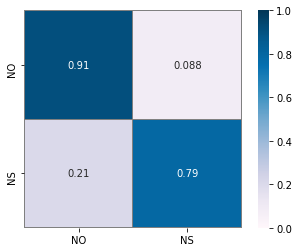

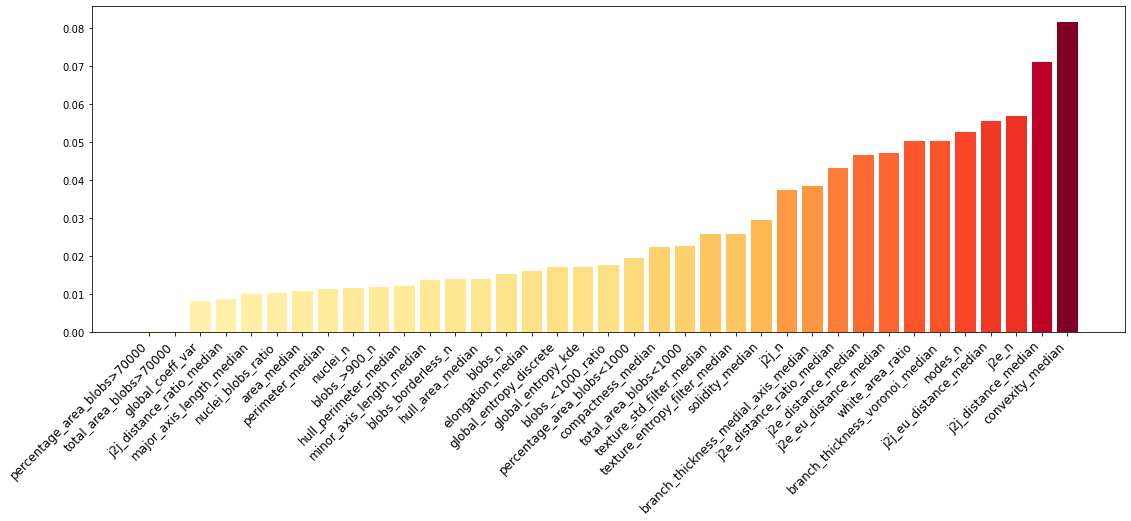

In [22]:
current_data = X_all
clf = RandomForestClassifier(oob_score=True, max_features="sqrt", n_estimators=2000, random_state=0)
clf.fit(current_data, y)

predicted_index = clf.oob_decision_function_.argmax(axis=1)
predicted = np.array(list(clf.classes_[i] for i in predicted_index))
print(classification_report(y, predicted))

cmx = confusion_matrix(y, predicted, labels=clf.classes_)
cmx_norm = cmx / cmx.sum(axis=1)[:, np.newaxis]
cmx_df = pd.DataFrame(cmx_norm, index=clf.classes_, columns=clf.classes_)
sns.heatmap(cmx_df, square=True, cmap='PuBu', annot=True, linewidths=0.1, linecolor='gray', vmin=0, vmax=1)

plot_ft_importance(clf.feature_importances_, current_data.columns)

              precision    recall  f1-score   support

          NO       0.81      0.88      0.85        34
          NS       0.87      0.79      0.83        34

    accuracy                           0.84        68
   macro avg       0.84      0.84      0.84        68
weighted avg       0.84      0.84      0.84        68



(<Figure size 1332x432 with 1 Axes>, <AxesSubplot:>)

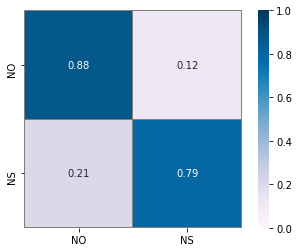

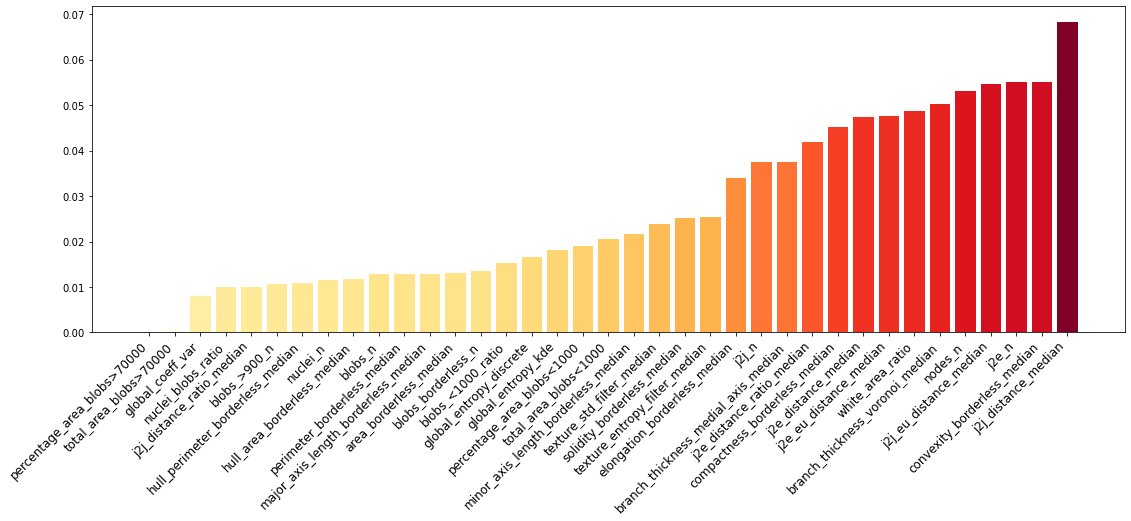

In [23]:
current_data = X_borderless
clf = RandomForestClassifier(oob_score=True, max_features="sqrt", n_estimators=2000, random_state=0)
clf.fit(current_data, y)

predicted_index = clf.oob_decision_function_.argmax(axis=1)
predicted = np.array(list(clf.classes_[i] for i in predicted_index))
print(classification_report(y, predicted))

cmx = confusion_matrix(y, predicted, labels=clf.classes_)
cmx_norm = cmx / cmx.sum(axis=1)[:, np.newaxis]
cmx_df = pd.DataFrame(cmx_norm, index=clf.classes_, columns=clf.classes_)
sns.heatmap(cmx_df, square=True, cmap='PuBu', annot=True, linewidths=0.1, linecolor='gray', vmin=0, vmax=1)

plot_ft_importance(clf.feature_importances_, current_data.columns)

              precision    recall  f1-score   support

          NO       0.79      0.88      0.83        34
          NS       0.87      0.76      0.81        34

    accuracy                           0.82        68
   macro avg       0.83      0.82      0.82        68
weighted avg       0.83      0.82      0.82        68



(<Figure size 1332x432 with 1 Axes>, <AxesSubplot:>)

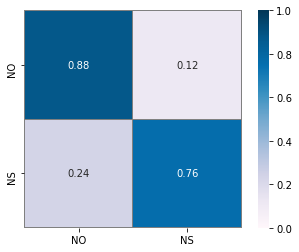

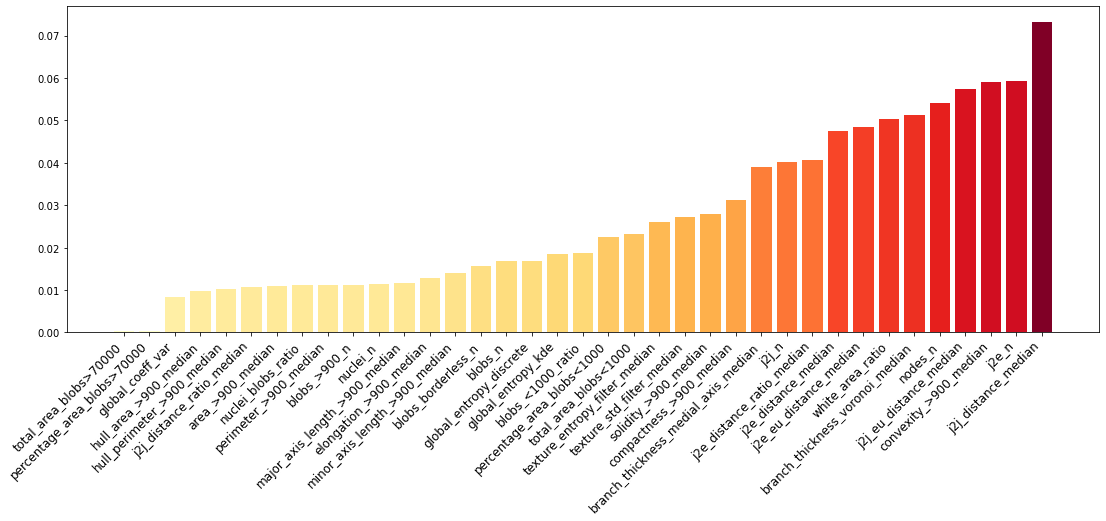

In [25]:
current_data = X_no_small
clf = RandomForestClassifier(oob_score=True, max_features="sqrt", n_estimators=2000, random_state=0)
clf.fit(current_data, y)

predicted_index = clf.oob_decision_function_.argmax(axis=1)
predicted = np.array(list(clf.classes_[i] for i in predicted_index))
print(classification_report(y, predicted))

cmx = confusion_matrix(y, predicted, labels=clf.classes_)
cmx_norm = cmx / cmx.sum(axis=1)[:, np.newaxis]
cmx_df = pd.DataFrame(cmx_norm, index=clf.classes_, columns=clf.classes_)
sns.heatmap(cmx_df, square=True, cmap='PuBu', annot=True, linewidths=0.1, linecolor='gray', vmin=0, vmax=1)

plot_ft_importance(clf.feature_importances_, current_data.columns)

In [26]:
generator = np.random.default_rng(seed=0)
n_iter = 10
rnd_states = generator.integers(0, 256, n_iter)
n_estimators = generator.integers(1500, 2500, n_iter)
fts_importance_list = []
for idx in range(n_iter):
    print(idx)
    clf = RandomForestClassifier(oob_score=True, max_features="sqrt", 
                                 n_estimators=n_estimators[idx], random_state=rnd_states[idx])
    clf.fit(X_borderless, y)
    predicted_index = clf.oob_decision_function_.argmax(axis=1)
    predicted = np.array(list(clf.classes_[i] for i in predicted_index))
    print(classification_report(y, predicted))
    fts_importance_list.append(clf.feature_importances_)

0
              precision    recall  f1-score   support

          NO       0.81      0.88      0.85        34
          NS       0.87      0.79      0.83        34

    accuracy                           0.84        68
   macro avg       0.84      0.84      0.84        68
weighted avg       0.84      0.84      0.84        68

1
              precision    recall  f1-score   support

          NO       0.81      0.88      0.85        34
          NS       0.87      0.79      0.83        34

    accuracy                           0.84        68
   macro avg       0.84      0.84      0.84        68
weighted avg       0.84      0.84      0.84        68

2
              precision    recall  f1-score   support

          NO       0.82      0.91      0.86        34
          NS       0.90      0.79      0.84        34

    accuracy                           0.85        68
   macro avg       0.86      0.85      0.85        68
weighted avg       0.86      0.85      0.85        68

3
           

In [27]:
fts_importance_list = np.array(fts_importance_list)
fts_importance_10 = fts_importance_list.mean(axis=0)
fts_importance_10

array([0.01214653, 0.01173361, 0.01229952, 0.01135448, 0.04260189,
       0.02526185, 0.05304127, 0.01165245, 0.02026467, 0.03481953,
       0.05163662, 0.01328498, 0.01227228, 0.00996577, 0.0586531 ,
       0.04212861, 0.04477111, 0.03968063, 0.03617166, 0.06670379,
       0.05581978, 0.00923538, 0.05639665, 0.01120937, 0.01125967,
       0.01507122, 0.01936784, 0.00030343, 0.01912415, 0.00032854,
       0.04259705, 0.05644577, 0.02458756, 0.02486033, 0.01710645,
       0.01809618, 0.00774628])

(<Figure size 1332x432 with 1 Axes>, <AxesSubplot:>)

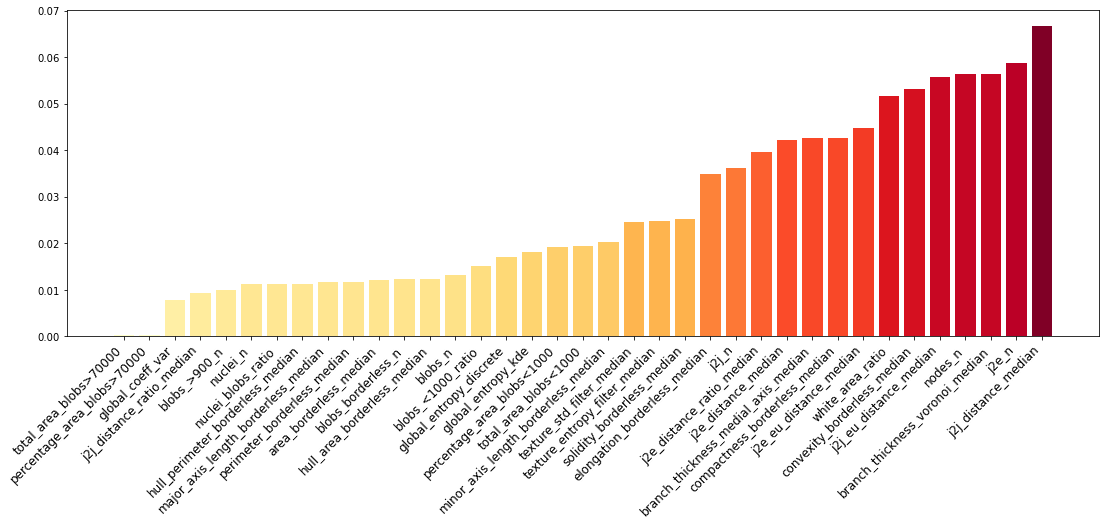

In [28]:
plot_ft_importance(fts_importance_10, X_borderless.columns)

In [29]:
ft_importance_dict = {k: v for k, v in zip(X_borderless.columns, fts_importance_10)}
ft_importance_dict

{'area_borderless_median': 0.012146528152716267,
 'perimeter_borderless_median': 0.011733610650262285,
 'hull_area_borderless_median': 0.012299516925419706,
 'hull_perimeter_borderless_median': 0.011354480299928226,
 'compactness_borderless_median': 0.04260188683646032,
 'solidity_borderless_median': 0.025261847962518756,
 'convexity_borderless_median': 0.053041268149438894,
 'major_axis_length_borderless_median': 0.011652454870405168,
 'minor_axis_length_borderless_median': 0.020264668895285144,
 'elongation_borderless_median': 0.03481953103483128,
 'white_area_ratio': 0.05163662263130399,
 'blobs_n': 0.013284982467463846,
 'blobs_borderless_n': 0.012272283323420705,
 'blobs_>900_n': 0.009965770743533492,
 'j2e_n': 0.0586530973427843,
 'j2e_distance_median': 0.0421286133110481,
 'j2e_eu_distance_median': 0.044771107826581974,
 'j2e_distance_ratio_median': 0.03968063190610067,
 'j2j_n': 0.03617165903548618,
 'j2j_distance_median': 0.06670379497463227,
 'j2j_eu_distance_median': 0.05581

<AxesSubplot:>

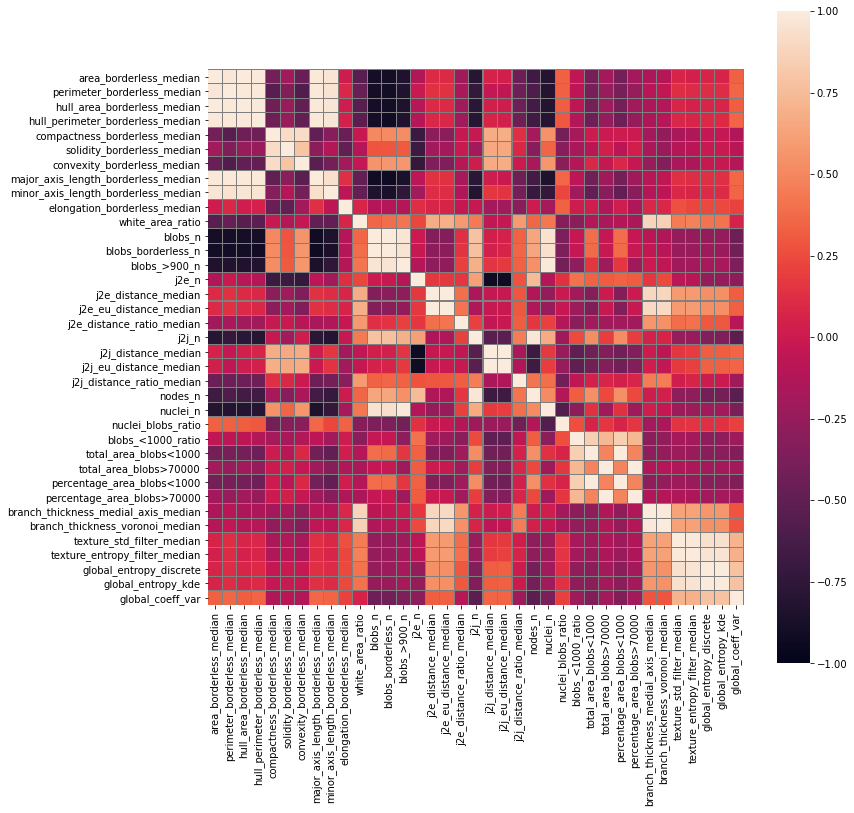

In [30]:
corr = X_borderless.corr()
plt.figure(figsize = (12,12))
sns.heatmap(corr, vmin=-1, vmax=1, square=True, linewidths=0.1, linecolor='gray')

<AxesSubplot:>

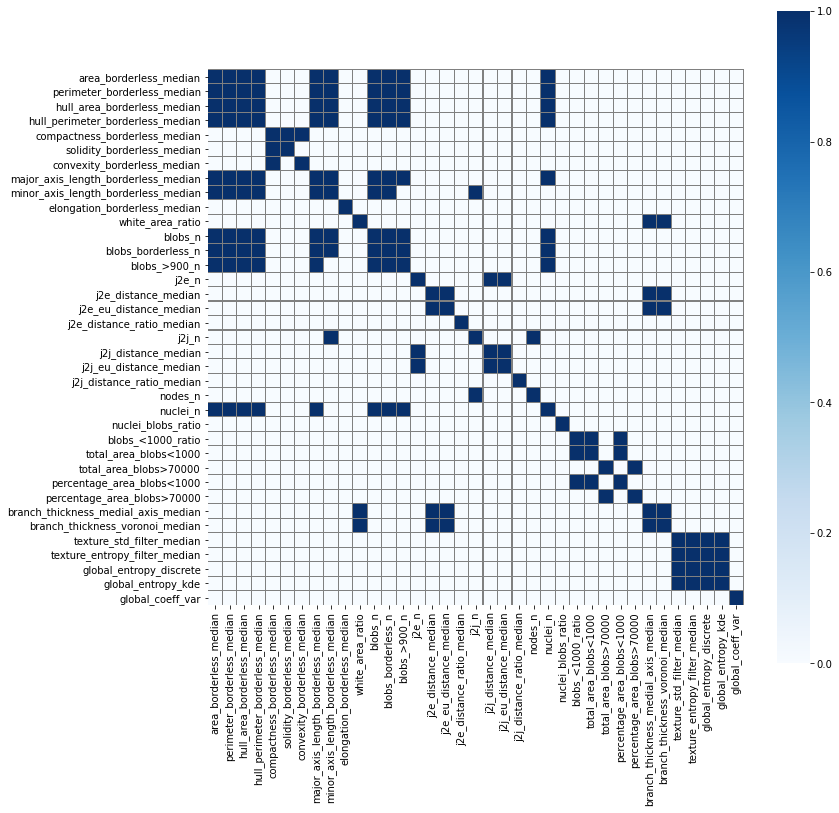

In [31]:
threshold = 0.8
thresh_corr = (abs(corr) > threshold).astype(int)
plt.figure(figsize = (12,12))
sns.heatmap(thresh_corr, vmin=0, vmax=1, square=True, cmap='Blues', linewidths=0.1, linecolor='gray')

In [32]:
def get_uncorrelated_columns(corr_df, theshold, ft_importance_dict): 
    keep = []
    remove = []
    thresh_corr_df = (abs(corr_df) > threshold).astype(int) 
    graph = nx.from_pandas_adjacency(thresh_corr_df)
    connected_components = nx.connected_components(graph)
    for component in connected_components:
        if len(component) == 1:
            keep.append(component.pop())
        else:
            current_ft_imp = {ft: ft_importance_dict[ft] for ft in component}
            max_ft = max(current_ft_imp, key=current_ft_imp.get)
            rest = [ft for ft in component if ft != max_ft]
            keep.append(max_ft)
            remove += rest
    return keep, remove


In [33]:
keep, remove = get_uncorrelated_columns(corr, threshold, ft_importance_dict)
keep, remove

(['nodes_n',
  'convexity_borderless_median',
  'elongation_borderless_median',
  'branch_thickness_voronoi_median',
  'j2j_distance_median',
  'j2e_distance_ratio_median',
  'j2j_distance_ratio_median',
  'nuclei_blobs_ratio',
  'total_area_blobs<1000',
  'percentage_area_blobs>70000',
  'texture_entropy_filter_median',
  'global_coeff_var'],
 ['j2j_n',
  'nuclei_n',
  'area_borderless_median',
  'major_axis_length_borderless_median',
  'hull_area_borderless_median',
  'blobs_n',
  'blobs_borderless_n',
  'blobs_>900_n',
  'hull_perimeter_borderless_median',
  'minor_axis_length_borderless_median',
  'perimeter_borderless_median',
  'compactness_borderless_median',
  'solidity_borderless_median',
  'branch_thickness_medial_axis_median',
  'j2e_distance_median',
  'j2e_eu_distance_median',
  'white_area_ratio',
  'j2e_n',
  'j2j_eu_distance_median',
  'blobs_<1000_ratio',
  'percentage_area_blobs<1000',
  'total_area_blobs>70000',
  'global_entropy_discrete',
  'global_entropy_kde',
  

In [34]:
#X_borderless_filtered = X_borderless[keep]
X_borderless_filtered = X_borderless[['j2j_distance_median', 
                                      'branch_thickness_voronoi_median',
                                      'convexity_borderless_median',
                                      'nodes_n']]
X_borderless_filtered

,j2j_distance_median,branch_thickness_voronoi_median,convexity_borderless_median,nodes_n
NegsiRNA_E3_NO,40.266715,8.944272,0.927603,2187
NegsiRNA_L2_NS,38.601632,6.000000,0.925205,1639
NegsiRNA_H3_NO,43.120287,10.295630,0.937294,1850
NegsiRNA_G3_NS,55.349168,7.615773,0.944047,1432
NegsiRNA_B1_NO,46.250846,10.000000,0.951059,1891
...,...,...,...,...
NegsiRNA_I2_NO,44.198083,8.544003,0.934052,1894
NegsiRNA_G3_NO,38.842477,9.899495,0.910640,1943
NegsiRNA_A1_NO,49.259924,11.000000,0.924468,1275
NegsiRNA_I3_NO,42.329852,8.944272,0.929273,1813


In [35]:
generator = np.random.default_rng(seed=0)
n_iter = 10
rnd_states = generator.integers(0, 256, n_iter)
n_estimators = generator.integers(1500, 2500, n_iter)
fts_importance_list = []
accuracies = []
for idx in range(n_iter):
    print(idx)
    clf = RandomForestClassifier(oob_score=True, max_features="sqrt", 
                                 n_estimators=n_estimators[idx], random_state=rnd_states[idx])
    clf.fit(X_borderless_filtered, y)
    predicted_index = clf.oob_decision_function_.argmax(axis=1)
    predicted = np.array(list(clf.classes_[i] for i in predicted_index))
    print(classification_report(y, predicted))
    fts_importance_list.append(clf.feature_importances_)
    accuracy = (predicted == y).sum() / len(predicted)
    accuracies.append(accuracy)

0
              precision    recall  f1-score   support

          NO       0.88      0.85      0.87        34
          NS       0.86      0.88      0.87        34

    accuracy                           0.87        68
   macro avg       0.87      0.87      0.87        68
weighted avg       0.87      0.87      0.87        68

1
              precision    recall  f1-score   support

          NO       0.88      0.88      0.88        34
          NS       0.88      0.88      0.88        34

    accuracy                           0.88        68
   macro avg       0.88      0.88      0.88        68
weighted avg       0.88      0.88      0.88        68

2
              precision    recall  f1-score   support

          NO       0.83      0.85      0.84        34
          NS       0.85      0.82      0.84        34

    accuracy                           0.84        68
   macro avg       0.84      0.84      0.84        68
weighted avg       0.84      0.84      0.84        68

3
           

In [36]:
accuracies = np.array(accuracies)
accuracies.mean(), accuracies.std()

(0.8691176470588236, 0.015353391924868455)

(<Figure size 144x432 with 1 Axes>, <AxesSubplot:>)

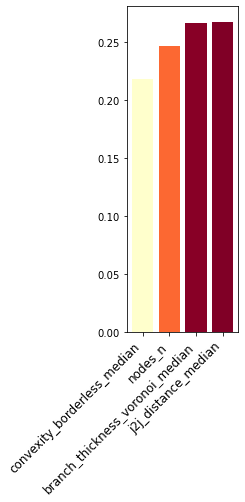

In [37]:
fts_importance_list = np.array(fts_importance_list)
fts_importance_10 = fts_importance_list.mean(axis=0)
plot_ft_importance(fts_importance_10, X_borderless_filtered.columns)

<AxesSubplot:>

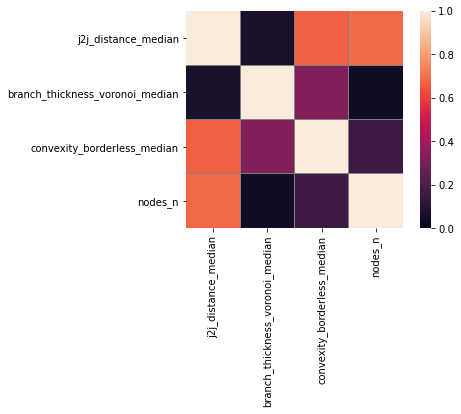

In [38]:
corr_filtered = X_borderless_filtered.corr()
sns.heatmap(abs(corr_filtered), vmin=-0, vmax=1, square=True, linewidths=0.1, linecolor='gray')

Text(0, 0.5, 'branch_thickness_voronoi_median')

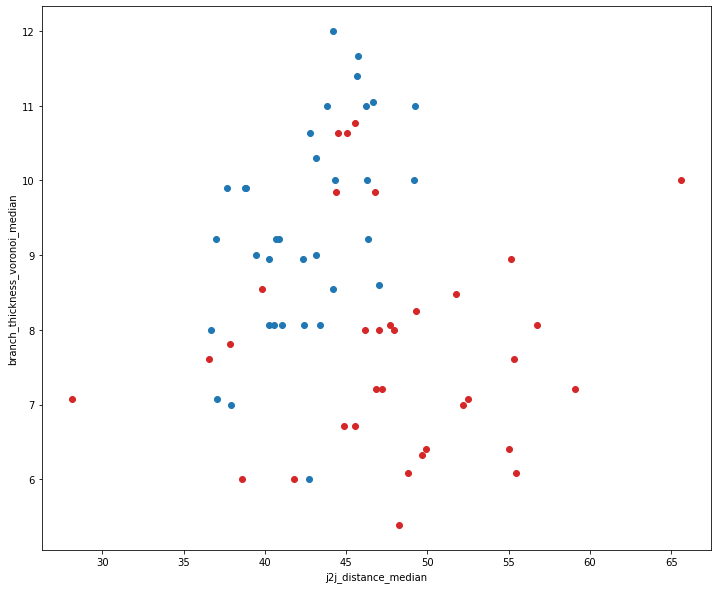

In [39]:
ns_data = X_borderless_filtered[df_negsi['stimulus'] == 'NS']
no_data = X_borderless_filtered[df_negsi['stimulus'] == 'NO']
x_ft = 'j2j_distance_median'
y_ft = 'branch_thickness_voronoi_median'
plt.figure(figsize=(12, 10))
plt.scatter(ns_data[x_ft], ns_data[y_ft], color='tab:red')
plt.scatter(no_data[x_ft], no_data[y_ft], color='tab:blue')
plt.xlabel(x_ft)
plt.ylabel(y_ft)

In [40]:
df_just_2 = X[['j2j_distance_median', 'branch_thickness_voronoi_median']]
clf_just_2 = Pipeline([('model', SVC(kernel='linear', C=100))])
#param_grid = [
 # {'model__C': np.arange(0.1, 1000, 10)},
#]

#clf = GridSearchCV(pipe, param_grid, n_jobs=-1)
#print("Best parameter (CV score=%0.3f):" % clf.best_score_)
#print(clf.best_params_)
scores = cross_val_score(clf_just_2, df_just_2, y, cv=10)
scores.mean(), scores.std()

(0.8261904761904763, 0.08521681032463464)

In [41]:
clf_just_2.fit(df_just_2, y)
y_pred = clf_just_2.predict(df_just_2)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

          NO       0.78      0.94      0.85        34
          NS       0.93      0.74      0.82        34

    accuracy                           0.84        68
   macro avg       0.85      0.84      0.84        68
weighted avg       0.85      0.84      0.84        68



(<Figure size 1080x720 with 1 Axes>,
 <AxesSubplot:xlabel='j2j_distance_median', ylabel='branch_thickness_voronoi_median'>)

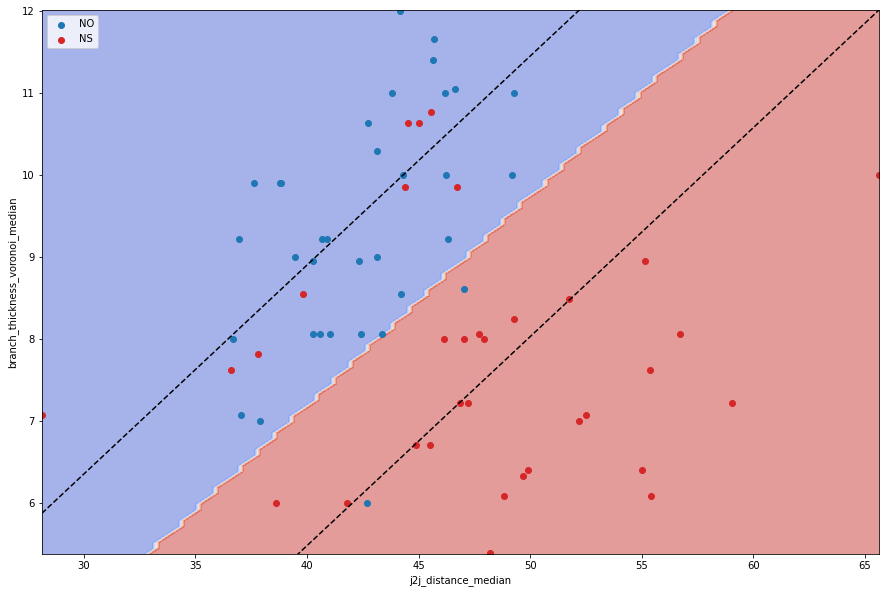

In [44]:
plot_boundaries(df_just_2, y, clf_just_2, 'j2j_distance_median', 'branch_thickness_voronoi_median', plot_lines=False, plot_margin=True)

In [46]:
clf_just_2

Pipeline(steps=[('model', SVC(C=100, kernel='linear'))])

In [48]:
import pickle
with open('../models/20210408_top_2_features_svm.pkl', 'wb') as model_file:
    pickle.dump(clf_just_2, model_file)

In [39]:
def get_pca_df(df):
    n_components = len(df.columns)
    columns = [f'pc_{iii}' for iii in range(1, n_components + 1)]
    pipe = Pipeline([('scaler', MinMaxScaler()), ('pca', PCA(n_components=n_components))]) # normalization and PCA
    df_pca_values = pipe.fit_transform(df)
    df_pca = pd.DataFrame(data=df_pca_values, index=df.index, columns=columns)
    return df_pca, pipe

In [40]:
df_pca, pipe_pca = get_pca_df(X_borderless_filtered)
df_pca

,pc_1,pc_2,pc_3,pc_4
NegsiRNA_E3_NO,-0.247037,-0.142875,-0.120844,-0.051354
NegsiRNA_L2_NS,0.039466,-0.351392,0.303536,0.087587
NegsiRNA_H3_NO,-0.171737,0.166074,-0.109805,0.058329
NegsiRNA_G3_NS,0.311475,0.131970,0.200179,-0.086970
NegsiRNA_B1_NO,0.015343,0.188474,-0.220513,0.046216
...,...,...,...,...
NegsiRNA_I2_NO,-0.059445,-0.044760,-0.007946,-0.021857
NegsiRNA_G3_NO,-0.466278,-0.018526,0.080426,-0.022328
NegsiRNA_A1_NO,-0.193014,0.453007,0.243033,0.040524
NegsiRNA_I3_NO,-0.145377,-0.007856,0.043677,0.023402


Text(0, 0.5, 'pc_2')

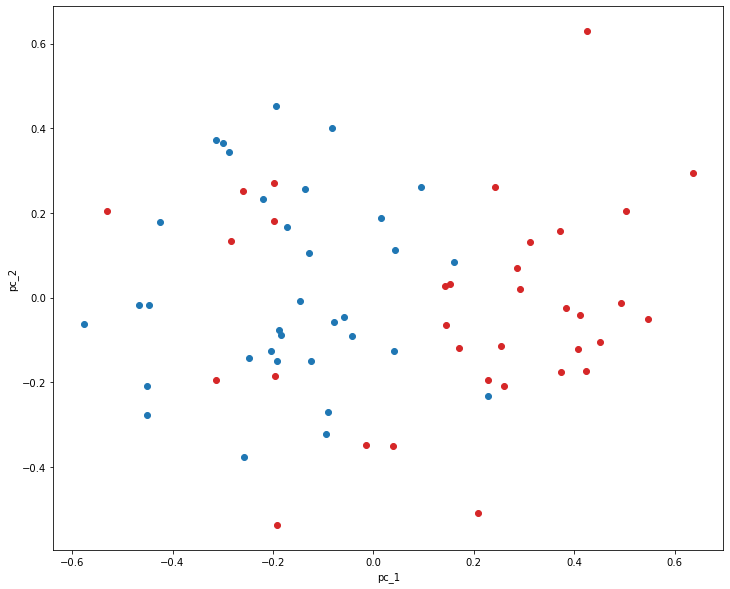

In [41]:
ns_data = df_pca[df_negsi['stimulus'] == 'NS']
no_data = df_pca[df_negsi['stimulus'] == 'NO']
x_ft = 'pc_1'
y_ft = 'pc_2'
plt.figure(figsize=(12, 10))
plt.scatter(ns_data[x_ft], ns_data[y_ft], color='tab:red')
plt.scatter(no_data[x_ft], no_data[y_ft], color='tab:blue')
plt.xlabel(x_ft)
plt.ylabel(y_ft)

Text(0, 0.5, 'Cumulative explained variance')

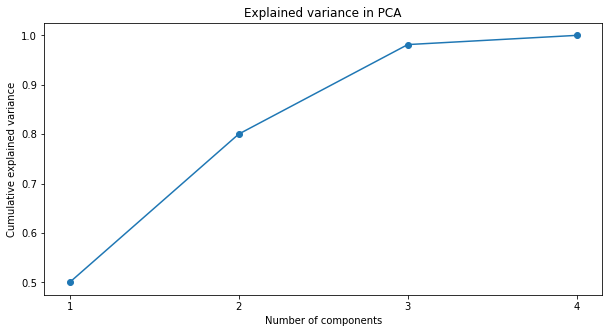

In [42]:
explained_variance_cumsum = pipe_pca['pca'].explained_variance_ratio_.cumsum()
plt.figure(figsize=(10, 5))
plt.plot(range(1, 5), explained_variance_cumsum, 'o-')
plt.xticks(range(1, 5))
plt.title('Explained variance in PCA')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [43]:
df_pca_2ft = df_pca[['pc_1', 'pc_2']]
clf = Pipeline([('model', SVC(kernel='linear', C=100))])
#param_grid = [
 # {'model__C': np.arange(0.1, 1000, 10)},
#]

#clf = GridSearchCV(pipe, param_grid, n_jobs=-1)
#print("Best parameter (CV score=%0.3f):" % clf.best_score_)
#print(clf.best_params_)
scores = cross_val_score(clf, df_pca_2ft, y, cv=10)
scores.mean(), scores.std()

(0.8285714285714285, 0.1538618516324144)

In [44]:
clf.fit(df_pca_2ft, y)
y_pred = clf.predict(df_pca_2ft)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

          NO       0.79      0.91      0.85        34
          NS       0.90      0.76      0.83        34

    accuracy                           0.84        68
   macro avg       0.85      0.84      0.84        68
weighted avg       0.85      0.84      0.84        68



In [43]:
def plot_boundaries(X, y, clf, x_coord, y_coord, n_points=100, plot_lines=True, add_text=False, plot_margin=False):
    colors = {'NS': 'tab:red', 'NO': 'tab:blue'}
    model = clf['model']
    padding = 0.01
    

    min_x = X[x_coord].min() - padding
    max_x = X[x_coord].max() + padding
    min_y = X[y_coord].min() - padding
    max_y = X[y_coord].max() + padding
    
    #min_x = -1 - padding
    #max_x = 1 + padding
    #min_y = -1 - padding
    #max_y = 1 + padding

    #min_x = min_y = 0
    #max_x = max_y = 5
    xx, yy = np.meshgrid(np.linspace(min_x, max_x, n_points), np.linspace(min_y, max_y, n_points))

    predictions = model.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    fig, axes = plt.subplots(1, figsize=(15, 10))

    axes.contourf(xx, yy, np.sign(predictions), cmap=plt.cm.coolwarm, alpha=0.5)
    # axes.contour(xx, yy, predictions, colors='k', levels=[-1, 0, 1], alpha=0.8, linestyles=['--', '-', '--'])

    for label in ['NO', 'NS']:
        current_X = X[y == label]
        axes.scatter(current_X[x_coord], current_X[y_coord], label=label, color=colors[label])

    if add_text:
        for index, row in X.iterrows():
            x0, y0 = row[x_coord], row[y_coord]
            if (min_x <= x0 <= max_x) and (min_y <= y0 <= max_y): 
                axes.text(x0 + padding / 10, y0 + padding / 10, index)
            else:
                print(f'{index} protein exceeds the limits (x={x0}, y={y0})')

    if plot_lines:
        name_and_plate = set("_".join(name.split("_")[:-1]) for name in X.index)

        for nap in name_and_plate:
            x0, y0 = X.loc[f'{nap}_NS', x_coord], X.loc[f'{nap}_NS', y_coord]
            x1, y1 = X.loc[f'{nap}_NO', x_coord], X.loc[f'{nap}_NO', y_coord]
            axes.plot((x0, x1), (y0, y1), c='gray')
            axes.plot((x0, x1), (y0, y1), c='gray')
    
    if plot_margin:
        w = model.coef_[0]
        a = -w[0] / w[1]
        xx2 = np.linspace(min_x, max_x)
        yy2 = a * xx2 - (model.intercept_[0]) / w[1]
        margin = 1 / np.sqrt(np.sum(model.coef_ ** 2))
        yy_down = yy2 - np.sqrt(1 + a ** 2) * margin
        yy_up = yy2 + np.sqrt(1 + a ** 2) * margin

        axes.plot(xx2, yy_down, 'k--')
        axes.plot(xx2, yy_up, 'k--')

    axes.set_xlabel(x_coord)
    axes.set_ylabel(y_coord)
    axes.set_xlim((min_x, max_x))
    axes.set_ylim((min_y, max_y))
    axes.legend()

    return fig, axes

(<Figure size 1080x720 with 1 Axes>,
 <AxesSubplot:xlabel='pc_1', ylabel='pc_2'>)

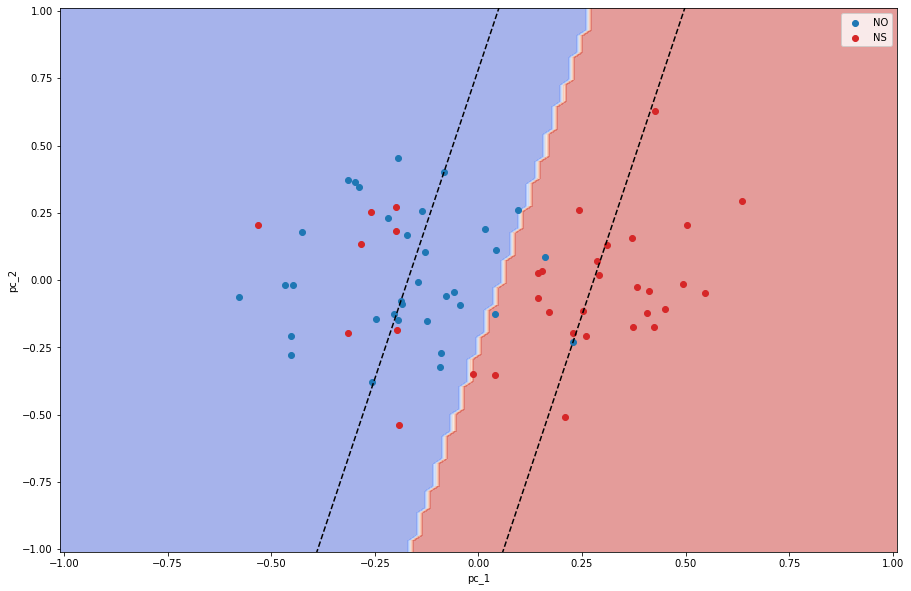

In [106]:
plot_boundaries(df_pca_2ft, y, clf, 'pc_1', 'pc_2', plot_lines=False, plot_margin=True)

In [56]:
df_rest = df[(df['protein'] != 'NegsiRNA') & (df['stimulus'] != 'CA')]
df_rest

,protein,plate,stimulus,white_area_ratio,area_mean,area_std,area_median,area_mad,area_mode,perimeter_mean,...,texture_std_filter_mad,texture_std_filter_mode,texture_entropy_filter_mean,texture_entropy_filter_std,texture_entropy_filter_median,texture_entropy_filter_mad,texture_entropy_filter_mode,global_entropy_discrete,global_entropy_kde,global_coeff_var
AKT1_B2_NO,AKT1,B2,NO,0.330304,9813.732919,6.168496e+03,9421.0,3578.0,630,439.762406,...,694.106445,1188.369629,4.154108,0.523035,4.191269,0.372221,4.354190,5.791014,5.803408,0.540478
ACTN1_B2_NS,ACTN1,B2,NS,0.129066,14470.070423,1.163439e+04,13463.5,8544.0,103,554.889710,...,195.372681,328.295410,2.868770,0.649364,2.851499,0.478579,2.849392,4.032616,4.038002,0.483366
JUP_D1_NO,JUP,D1,NO,0.291828,6875.662551,4.192131e+03,6626.0,3009.0,4465,357.621712,...,266.486145,453.509460,3.290104,0.592684,3.279088,0.426149,3.244624,4.464059,4.480448,0.449110
CTNNB1_A1_NS,CTNNB1,A1,NS,0.221042,14820.887097,1.137919e+04,12763.0,8194.0,156,541.275670,...,666.926758,968.437134,4.047129,0.570934,4.090811,0.404744,4.272607,5.622796,5.639039,0.554752
FYN_E3_NS,FYN,E3,NS,0.252473,11233.356688,6.133822e+03,10890.0,3665.0,17118,456.227522,...,407.968201,685.691772,3.663046,0.595786,3.660657,0.425607,3.619014,5.001731,5.014991,0.533885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CTNNA1_A1_NS,CTNNA1,A1,NS,0.112984,28280.108108,1.122986e+05,1968.5,1929.5,7,755.610417,...,541.477783,786.701843,3.878884,0.574353,3.900625,0.422571,3.971705,5.356887,5.370032,0.502351
DNMBP_A3_NO,DNMBP,A3,NO,0.226212,11854.506494,9.443554e+03,10429.0,6573.5,16540,495.713790,...,361.706299,848.246582,3.642820,0.560697,3.674024,0.366493,3.814399,4.907667,4.917749,0.526467
CDH1_B1_NS,CDH1,B1,NS,0.008041,780108.333333,1.348136e+06,3070.0,2616.0,454,4935.412540,...,206.110138,409.006592,3.097695,0.600949,3.058033,0.424753,3.067851,4.345918,4.386877,0.498646
CTNNA1_A3_NO,CTNNA1,A3,NO,0.153547,11816.662722,1.524681e+04,8115.0,7508.0,178,480.798606,...,279.118835,525.445984,3.328485,0.597775,3.338016,0.426792,3.273900,4.569930,4.580187,0.455083


In [57]:
X_rest = df_rest[X_borderless_filtered.columns]
y_rest = df_rest['stimulus']
X_rest

,j2j_distance_median,branch_thickness_voronoi_median,convexity_borderless_median,nodes_n
AKT1_B2_NO,48.069156,10.295630,0.938025,1585
ACTN1_B2_NS,50.655844,2.236068,0.924240,1416
JUP_D1_NO,50.074665,7.211102,0.961744,1888
CTNNB1_A1_NS,30.810270,7.615773,0.937370,1244
FYN_E3_NS,62.930409,7.810250,0.956283,1343
...,...,...,...,...
CTNNA1_A1_NS,44.970068,4.242640,0.990028,1145
DNMBP_A3_NO,38.475662,6.403124,0.913420,1867
CDH1_B1_NS,35.191967,2.236068,0.955580,131
CTNNA1_A3_NO,31.620231,4.123106,0.951312,1903


In [58]:
X_rest_ns = X_rest[y_rest == 'NS']
y_rest_ns = y_rest[y_rest == 'NS']
X_rest_ns

,j2j_distance_median,branch_thickness_voronoi_median,convexity_borderless_median,nodes_n
ACTN1_B2_NS,50.655844,2.236068,0.924240,1416
CTNNB1_A1_NS,30.810270,7.615773,0.937370,1244
FYN_E3_NS,62.930409,7.810250,0.956283,1343
GNA12_E1_NS,62.894531,8.544003,0.961376,1213
ACTB_B2_NS,46.246636,13.341664,0.939078,1796
...,...,...,...,...
P2RX4_E1_NS,53.668524,7.810250,0.943605,1314
ACTN4_L1_NS,49.048343,7.000000,0.953061,1986
MYO7A_D3_NS,48.956333,7.810250,0.941394,1567
CTNNA1_A1_NS,44.970068,4.242640,0.990028,1145


In [59]:
n_components = len(X_rest_ns.columns)
columns = [f'pc_{iii}' for iii in range(1, n_components+1)]
pca_values = pipe_pca.transform(X_rest_ns)
df_pca_rest_ns = pd.DataFrame(data=pca_values, index=X_rest_ns.index, columns=columns)

CDH1_B2_NS protein exceeds the limits (x=-8.833459744561944, y=-1.9626960104732591)
CTNNA1_A3_NS protein exceeds the limits (x=1.134798597173511, y=-0.10103757590340438)


(<Figure size 1080x720 with 1 Axes>,
 <AxesSubplot:xlabel='pc_1', ylabel='pc_2'>)

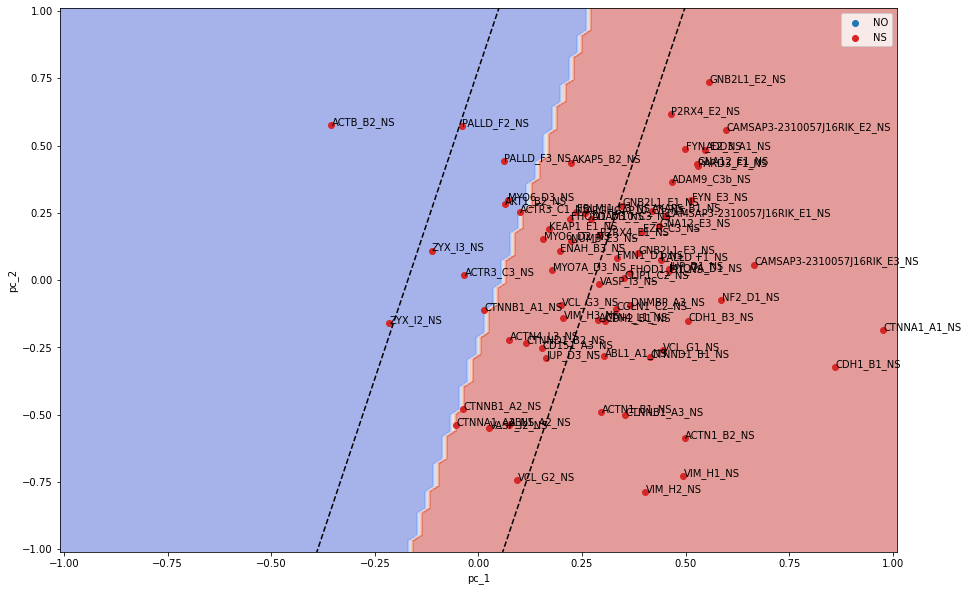

In [108]:
plot_boundaries(df_pca_rest_ns, y_rest_ns, clf, 'pc_1', 'pc_2', plot_lines=False, add_text=True, plot_margin=True)

In [50]:
upper_thresh = 40000
lower_thresh = 900
n_blobs_dict = {}
for name, df in dfs.items():
    df_filtered = df[~(df['is_at_border']) & (df['area'] > lower_thresh) & (df['area'] < upper_thresh)]
    n_blobs_dict[name] = len(df_filtered)

In [113]:
import pickle
with open('../models/20210405_pca_svm.pkl', 'wb') as model_file:
    pickle.dump(pipe_pca, model_file)

In [114]:
with open('../models/20210405_pca_svm.pkl', 'rb') as model_file:
    pipe_pca2 = pickle.load(model_file)

In [133]:
df_rest_just_2 = df_rest.loc[df_rest['stimulus'] == 'NS', ['j2j_distance_median', 'branch_thickness_voronoi_median']]
df_rest_just_2

,j2j_distance_median,branch_thickness_voronoi_median
ACTN1_B2_NS,50.655844,2.236068
CTNNB1_A1_NS,30.810270,7.615773
FYN_E3_NS,62.930409,7.810250
GNA12_E1_NS,62.894531,8.544003
ACTB_B2_NS,46.246636,13.341664
...,...,...
P2RX4_E1_NS,53.668524,7.810250
ACTN4_L1_NS,49.048343,7.000000
MYO7A_D3_NS,48.956333,7.810250
CTNNA1_A1_NS,44.970068,4.242640


In [134]:
y_rest_just_2 = df_rest.loc[df_rest['stimulus'] == 'NS', 'stimulus']
y_rest_just_2

ACTN1_B2_NS     NS
CTNNB1_A1_NS    NS
FYN_E3_NS       NS
GNA12_E1_NS     NS
ACTB_B2_NS      NS
                ..
P2RX4_E1_NS     NS
ACTN4_L1_NS     NS
MYO7A_D3_NS     NS
CTNNA1_A1_NS    NS
CDH1_B1_NS      NS
Name: stimulus, Length: 73, dtype: object

(<Figure size 1080x720 with 1 Axes>,
 <AxesSubplot:xlabel='j2j_distance_median', ylabel='branch_thickness_voronoi_median'>)

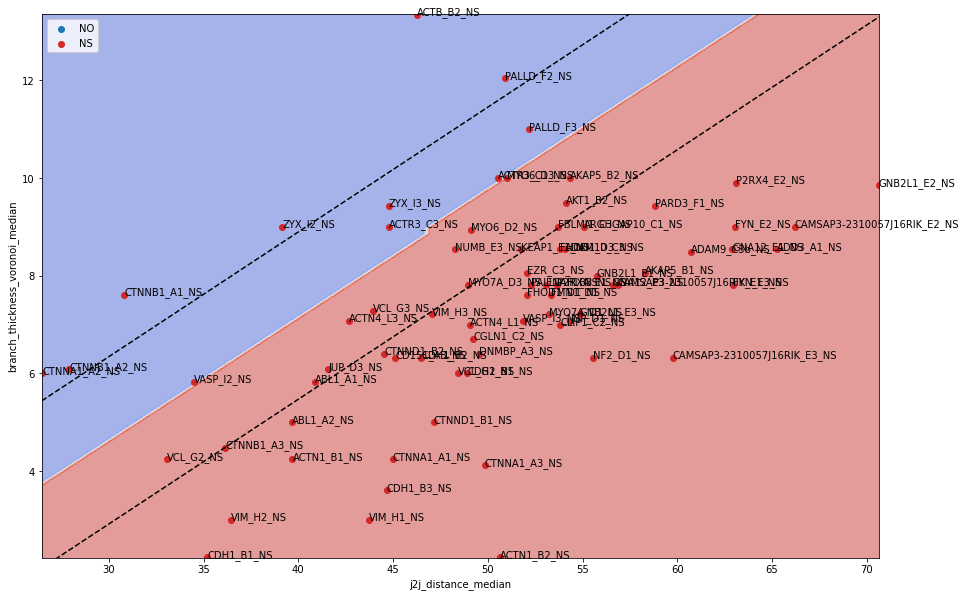

In [136]:
plot_boundaries(df_rest_just_2, y_rest_just_2, clf_just_2, 'j2j_distance_median', 'branch_thickness_voronoi_median', plot_lines=False, add_text=True, plot_margin=True)